In [1]:
from textrank4zh import TextRank4Keyword,TextRank4Sentence
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import jieba.analyse
import os
import pickle
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

/anaconda3/envs/DataSci/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# GET_KEYWORDS
def get_keywords(x):
    if pd.isna(x):
        return np.nan
    else:
        # TEXTRANK TOP 10
        tr4w = TextRank4Keyword(stop_words_file='./base_data/stopword.data')
        tr4w.train(text=x, speech_tag_filter=True, lower=True, window=2)
        keywords_textrank = tr4w.get_keywords(10, word_min_len=2)
        # Top_10 TF_IDF words
        keywords_tfidf = jieba.analyse.extract_tags(x)[:10]
        # Intersection
        result_ = list(set(keywords_textrank).intersection(set(keywords_tfidf)))
        return result_

In [3]:
# READ_DATA
df = pd.read_csv('./raw_data/datawithcor.csv')
# DROP NAN
df = df[df.Fatality_Rate.notna()]
df = df[df.Narrative.notna()]

In [4]:
# KEYWORDS EXTRACTION
df['key_words'] = df.Narrative.apply(lambda x: get_keywords(x))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/pj/mrvgnnps0n92zyj8t94f613r0000gn/T/jieba.cache
Loading model cost 0.763 seconds.
Prefix dict has been built successfully.


In [5]:
# SET X and Y
x_columns = ['year', 'Type', 'Operator', 'Lat', 'Long', 'key_words']
y_columns = 'Fatality_Rate'

In [6]:
# PRE_TRAIN
# Lat, Long ABS
df.Lat = df.Lat.abs()
df.Long = df.Long.abs()

In [7]:
# Order Map
type_dict = {'Caproni': 0, 'Felixstowe': 1}
operator_dict = {'Caproni': 0, 'Royal Air Force - RAF': 1}
df.Type = df.Type.map(type_dict)
df.Operator = df.Operator.map(operator_dict)

In [8]:
# TF_IDF
# 'Pre_Train, join null intro words
df['key_words_new'] = df.key_words.apply(lambda x: ' '.join(x))
# tfidf
tf_train = TfidfVectorizer()
tf_result = tf_train.fit_transform(df.key_words_new.tolist())

In [9]:

if os.path.exists('./base_data/vocabulary.json'):
    os.remove('./base_data/vocabulary.json')
if os.path.exists('./base_data/idfs.npy'):
    os.remove('./base_data/idfs.npy')
f1 = open('./base_data/vocabulary.json', 'wb')
file = tf_train.vocabulary_
pickle.dump(file,f1)
f1.close()
idfs = tf_train.idf_
np.save('./base_data/idfs.npy',idfs)
# 
# idfs = np.load('./base_data/idfs_con.npy')
# x_list = [[contents_[i],add_info[i],x_list_1[i],x_list_2[i]] for i in range(len(x_list_1))]
# vocabulary_import = pickle.load(open('./base_data/vocabulary_con.json','rb'))
# tf_train = MyVectorizer(vocabulary = vocabulary_import)
# tf_train._tfidf._idf_diag = sp.spdiags(idfs,
#                                      diags = 0,
#                                      m = len(idfs),
#                                      n = len(idfs))

In [10]:
# 'Merge TD_IDF'
a = df[x_columns[:-1]]
all_feature = np.hstack((a,  tf_result.toarray()))

In [11]:
# Model Building
# Set split
x_train, x_test, y_train, y_test = train_test_split(all_feature, df[y_columns],  test_size=0.3, random_state=0)

In [12]:
# lgb
gbm = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=100)
gbm.fit(x_train, y_train)
y_pre = gbm.predict(x_test)
print('mse: ', mean_squared_error(y_test, y_pre))

mse:  0.1362350917314941


In [13]:
import xgboost as xgb
bat =  xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
             reg_alpha=0.8, reg_lambda=0.5, scale_pos_weight=1, seed=4396,
             silent=None, subsample=0.8,verbosity=1)
bat.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
             reg_alpha=0.8, reg_lambda=0.5, scale_pos_weight=1, seed=4396,
             silent=None, subsample=0.8, verbosity=1)

In [14]:
mean_squared_error(bat.predict(x_test),y_test)
np.mean(x_test)

nan

In [15]:
np.mean(y_test)
np.mean(y_train)

0.44351799921360724

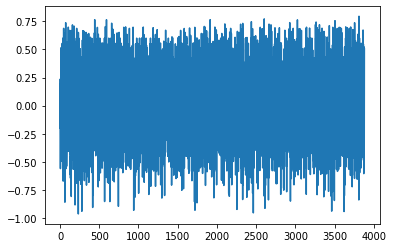

In [16]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(y_test))],bat.predict(x_test)-y_test)

0.4410136719458038
1.0978915667644196
-0.1612117712356446
0.1362350917314941


Text(0.5, 1.0, 'BAT Predicted Values')

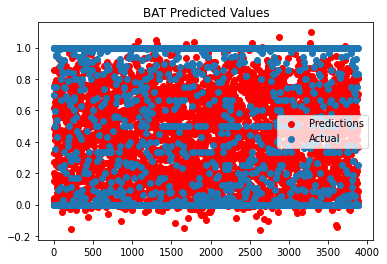

In [17]:
print(np.mean(gbm.predict(x_test)))
print(np.max(gbm.predict(x_test)))
print(np.min(gbm.predict(x_test)))
print(mean_squared_error(gbm.predict(x_test),y_test))
plt.scatter([i for i in range(len(y_test))],gbm.predict(x_test),color = 'red',label = 'Predictions')
plt.scatter([i for i in range(len(y_test))],y_test,label = 'Actual')
plt.legend()
plt.title('BAT Predicted Values')

In [18]:
x_train.shape

(9054, 3106)

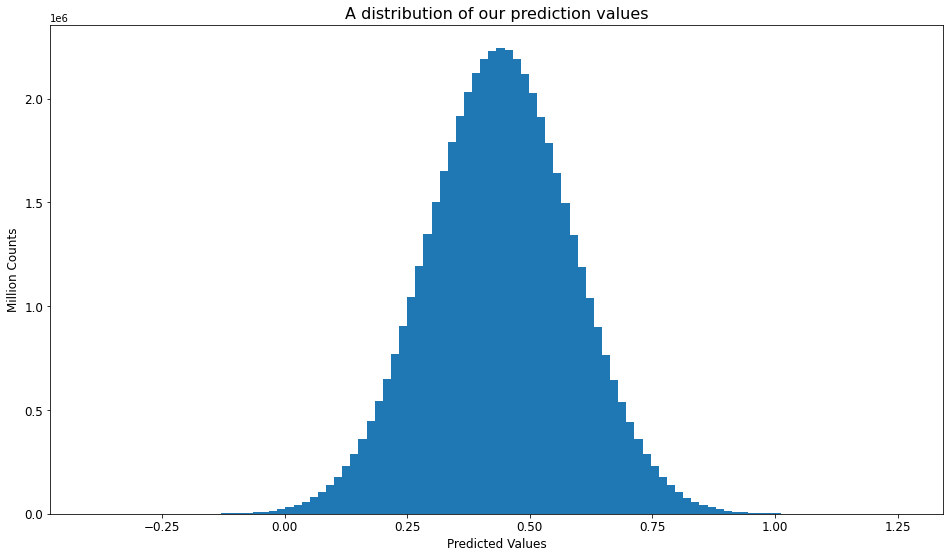

In [271]:
def demo1():
    mu ,sigma = 0.44, 0.147
    sampleNo = 50000000
    np.random.seed(0)
    s = np.random.normal(mu, sigma, sampleNo)
    plt.figure(figsize = (16,9))
    plt.hist(s, bins=100)
    plt.title("A distribution of our prediction values",fontsize = 16)
    plt.xlabel('Predicted Values',fontsize = 12)
    plt.ylabel('Million Counts',fontsize =12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.savefig('Demo.jpg')
demo1()

In [20]:
y_predict = bat.predict(x_test)
mae_test=np.sum(np.absolute(y_predict-y_test))/len(y_test)
print(mae_test)

0.334907576562423


In [21]:
y_predict = gbm.predict(x_test)
mae_test=np.sum(np.absolute(y_predict-y_test))/len(y_test)
print(mae_test)

0.30560708004666176


In [226]:
from collections import defaultdict
k = defaultdict(int)
for i in df['key_words']:
    for c in i:
        k[c]+=1
df['key_words']

0               [airfield, aircraft, flight, airliner]
1                                             [flight]
2                    [forced, landing, repair, rudder]
3                       [fire, plane, caught, landing]
4               [aircraft, passengers, crew, operated]
                             ...                      
14482    [suffered, aircraft, died, runway, excursion]
14483    [sign, flight, airplane, pilot, left, runway]
14484              [pilot, airplane, approach, ground]
14485               [suffered, runway, plane, landing]
14487                       [crashed, flames, takeoff]
Name: key_words, Length: 12935, dtype: object

In [227]:
import operator
sorted_x = sorted(k.items(),key = operator.itemgetter(1),reverse = True)
sorted_x

[('aircraft', 3701),
 ('flight', 3065),
 ('runway', 2807),
 ('landing', 1609),
 ('airplane', 1411),
 ('crew', 1384),
 ('pilot', 1136),
 ('takeoff', 1132),
 ('engine', 1112),
 ('approach', 1044),
 ('feet', 937),
 ('plane', 911),
 ('left', 872),
 ('crashed', 793),
 ('gear', 554),
 ('fire', 539),
 ('captain', 390),
 ('wing', 289),
 ('ground', 288),
 ('accident', 282),
 ('struck', 279),
 ('passengers', 268),
 ('operated', 260),
 ('departed', 252),
 ('nose', 251),
 ('weather', 246),
 ('mountain', 238),
 ('landed', 234),
 ('altitude', 228),
 ('reported', 226),
 ('failure', 224),
 ('power', 219),
 ('failed', 217),
 ('fuel', 215),
 ('control', 210),
 ('lost', 209),
 ('cargo', 201),
 ('route', 192),
 ('main', 190),
 ('forced', 186),
 ('time', 174),
 ('passenger', 171),
 ('damage', 166),
 ('side', 165),
 ('sea', 163),
 ('airport', 155),
 ('hijacker', 155),
 ('speed', 145),
 ('due', 144),
 ('short', 143),
 ('training', 138),
 ('conditions', 137),
 ('shortly', 137),
 ('flying', 136),
 ('engines', 136),
 ('transport', 135),
 ('sustained', 135),
 ('area', 131),
 ('impacted', 131),
 ('mission', 131),
 ('caught', 130),
 ('trees', 129),
 ('land', 127),
 ('emergency', 126),
 ('damaged', 126),
 ('water', 125),
 ('night', 124),
 ('knots', 123),
 ('high', 122),
 ('ft', 121),
 ('hijackers', 119),
 ('suffered', 118),
 ('turn', 117),
 ('poor', 117),
 ('hours', 117),
 ('repair', 116),
 ('hand', 113),
 ('terrain', 112),
 ('en', 110),
 ('minutes', 110),
 ('descent', 109),
 ('controller', 108),
 ('cleared', 104),
 ('officer', 104),
 ('de', 103),
 ('overran', 103),
 ('km', 102),
 ('destroyed', 99),
 ('snow', 98),
 ('hit', 97),
 ('hijacked', 96),
 ('undercarriage', 94),
 ('visibility', 92),
 ('collapsed', 92),
 ('demanded', 91),
 ('flew', 90),
 ('height', 90),
 ('collided', 88),
 ('causing', 88),
 ('carried', 85),
 ('touched', 85),
 ('substantial', 85),
 ('members', 83),
 ('propeller', 83),
 ('field', 82),
 ('approximately', 82),
 ('ran', 81),
 ('named', 80),
 ('pilots', 80),
 ('jet', 79),
 ('bad', 75),
 ('air', 74),
 ('taxiway', 73),
 ('fog', 72),
 ('crash', 72),
 ('wind', 72),
 ('metres', 72),
 ('heavy', 71),
 ('hill', 71),
 ('miles', 70),
 ('problems', 70),
 ('degrees', 70),
 ('airstrip', 69),
 ('departure', 68),
 ('test', 67),
 ('caused', 66),
 ('board', 65),
 ('broke', 64),
 ('threshold', 62),
 ('rain', 61),
 ('spraying', 60),
 ('final', 59),
 ('return', 58),
 ('drop', 58),
 ('loss', 57),
 ('icing', 57),
 ('wreckage', 56),
 ('climb', 56),
 ('approaching', 56),
 ('position', 56),
 ('missing', 55),
 ('touchdown', 55),
 ('pressure', 55),
 ('boat', 54),
 ('attempted', 54),
 ('fuselage', 54),
 ('roll', 53),
 ('shot', 52),
 ('entered', 52),
 ('flaps', 52),
 ('hard', 51),
 ('thrust', 51),
 ('carrying', 50),
 ('system', 50),
 ('ice', 49),
 ('bank', 49),
 ('crop', 49),
 ('hydraulic', 49),
 ('stalled', 48),
 ('visual', 48),
 ('clouds', 47),
 ('excursion', 47),
 ('meters', 47),
 ('copilot', 47),
 ('seconds', 47),
 ('killed', 46),
 ('burned', 46),
 ('level', 46),
 ('reportedly', 46),
 ('continued', 46),
 ('wheel', 45),
 ('commander', 45),
 ('tail', 44),
 ('contact', 44),
 ('cloud', 44),
 ('instrument', 44),
 ('cabin', 44),
 ('occupants', 43),
 ('attempting', 43),
 ('descended', 43),
 ('leg', 43),
 ('supply', 42),
 ('ditched', 41),
 ('ditch', 41),
 ('military', 41),
 ('aborted', 41),
 ('prop', 41),
 ('feathered', 40),
 ('operating', 39),
 ('wooded', 39),
 ('north', 39),
 ('dropping', 39),
 ('mountainous', 39),
 ('hijacking', 39),
 ('warning', 39),
 ('service', 38),
 ('cockpit', 38),
 ('slope', 38),
 ('man', 38),
 ('returning', 37),
 ('oil', 37),
 ('nosegear', 37),
 ('injured', 36),
 ('flames', 35),
 ('immediately', 35),
 ('impact', 35),
 ('began', 35),
 ('attitude', 35),
 ('burst', 34),
 ('covered', 34),
 ('started', 34),
 ('building', 34),
 ('steep', 34),
 ('pitch', 34),
 ('part', 33),
 ('maintenance', 33),
 ('local', 33),
 ('wet', 33),
 ('equipped', 32),
 ('long', 32),
 ('day', 32),
 ('stated', 32),
 ('kt', 32),
 ('attempt', 31),
 ('radio', 31),
 ('died', 31),
 

In [220]:
#sorted_x

In [228]:
l = []
for i,z in enumerate(bat.feature_importances_):
    l.append((i,z))
sorted_l = sorted(l,key = operator.itemgetter(1),reverse = True)
sorted_l = sorted_l[:11]
xlbl =  [str(i[0]) for i in sorted_l]
sorted_l = [i[1] for i in sorted_l]
print(sorted_l) 

[0.08699567, 0.059456617, 0.032274697, 0.030867463, 0.02891132, 0.026001437, 0.025946256, 0.025053818, 0.021039072, 0.017748943, 0.017394185]


[0.08699567, 0.059456617, 0.032274697, 0.030867463, 0.02891132, 0.026001437, 0.025946256, 0.021039072, 0.017748943, 0.017394185]


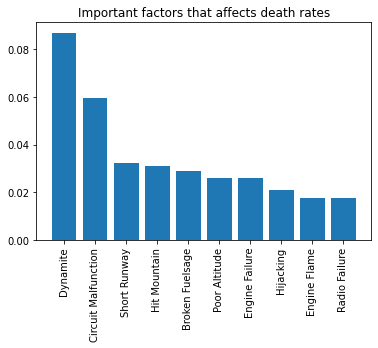

In [247]:
plt.xticks(rotation = 90)
#sorted_l.remove(sorted_l[7])
plt.title('Important factors that affects death rates')
plt.bar(parad_label,sorted_l)
print(sorted_l)

In [231]:
k = set()
for i in df['key_words_new']:
    k.add(i)
k = list(k)
x

[1485, 2370, 1292, 1484, 1293, 1179, 1740, 1291, 899, 621, 709]

[1485, 2370, 1292, 1484, 1293, 1179, 1740, 1291, 899, 621, 709]

In [243]:
parad_label = ['Dynamite','Circuit Malfunction','Short Runway','Hit Mountain','Broken Fuelsage','Poor Altitude','Engine Failure','Hijacking','Engine Flame'
            ,'Radio Failure']
parad_label.remove('Gold')
len(parad_label)

10

In [177]:
pickle.dump(bat, open("pima.pickle.dat", "wb"))
loaded_model = pickle.load(open("pima.pickle.dat", "rb"))

In [181]:
plg.bar

0.14156097098889578

In [234]:
l = list()
for i,z in enumerate(loaded_model.feature_importances_):
    if i in x:
        #print(i,z,k[i])
        l.append((i,z,k[i]))
l = sorted(l,key = lambda x:x[1],reverse = True)
print(l)

[(1485, 0.08699567, 'hijacker grenade flight return plane'), (2370, 0.059456617, 'circuit struck hill landing practice msl'), (1292, 0.032274697, 'feet short gear runway main'), (1484, 0.030867463, 'route forest en seat mountain passengers fire'), (1293, 0.02891132, 'skin fuselage left side'), (1179, 0.026001437, 'poor feet ceiling'), (1740, 0.025946256, 'engine landed failure injuries'), (1291, 0.025053818, 'gold'), (899, 0.021039072, 'hijacker hair jar flight gel brandished'), (621, 0.017748943, 'caused gear left fire engine main'), (709, 0.017394185, 'flight radio contact crew')]


In [235]:
#tf_result

In [186]:
pickle.dump(all_feature, open("all_feature.dat", "wb"))

In [190]:
#Overall
mean_squared_error(loaded_model.predict(all_feature), df[y_columns])

0.1433881657332438

In [191]:
#Test
mean_squared_error(bat.predict(x_test),y_test)

0.14765083546149083

In [192]:
#Train
mean_squared_error(bat.predict(x_train),y_train)

0.14156097098889578

<BarContainer object of 10 artists>

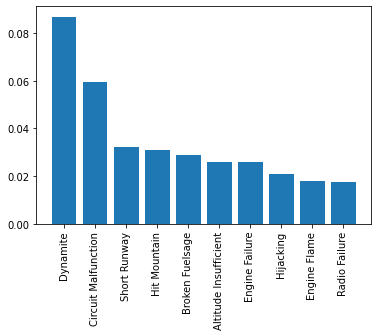

In [251]:
weights = [0.08699567, 0.059456617, 0.032274697, 0.030867463, 0.02891132, 0.026001437, 0.025946256, 0.021039072, 0.017748943, 0.017394185]
parad_label = ['Dynamite','Circuit Malfunction','Short Runway','Hit Mountain','Broken Fuelsage','Altitude Insufficient','Engine Failure','Hijacking','Engine Flame'
            ,'Radio Failure']
plt.xticks(rotation = 90)
plt.bar(parad_label,weights)

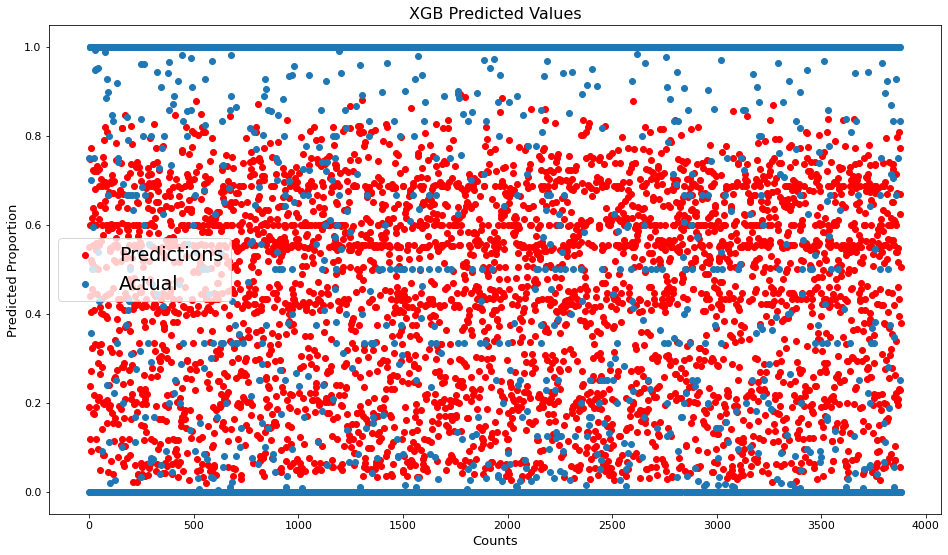

In [268]:
plt.figure(figsize = (16,9))
plt.scatter([i for i in range(len(y_test))],bat.predict(x_test),color = 'red',label = 'Predictions')
plt.scatter([i for i in range(len(y_test))],y_test,label = 'Actual')
plt.xlabel('Counts',fontsize= 13)
plt.ylabel('Predicted Proportion',fontsize = 13)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.legend(fontsize = 19)
plt.title('XGB Predicted Values',fontsize = 16)
plt.savefig('experiment4.jpg')